## 요약

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

# 그래프의 폰트 출력을 선명하게 (svg, retina 등이 있음)
matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
# 테마 설정: "default", "classic", "dark_background", "fivethirtyeight", "seaborn"
mpl.style.use("default")
# 이미지가 레이아웃 안으로 들어오도록 함
# https://matplotlib.org/stable/users/explain/axes/constrainedlayout_guide.html
mpl.rcParams.update({"figure.constrained_layout.use": True})

#font, line, marker 등의 배율 설정: paper, notebook, talk, poster
sns.set_context("paper") 
#배색 설정: tab10, Set2, Accent, husl
sns.set_palette("Set2") 
#눈금, 배경, 격자 설정: ticks, white, whitegrid, dark, darkgrid
# withegrid: 눈금을 그리고, 각 축의 눈금을 제거
sns.set_style("whitegrid") 

In [2]:
# 로컬에서 

plt.rc("font", family = "D2Coding")
plt.rcParams["axes.unicode_minus"] = False

In [3]:
# 필요한 패키지 import
from bs4 import BeautifulSoup
import requests
import re
import os

In [4]:
PRJCT_PATH = '/home/doeun/code/AI/ESTSOFT2024/workspace/2.project2/aladin_usedbook'

## 개요
- 국내 중고 도서 중 우주점 항목 페이지
  - https://www.aladin.co.kr/search/wsearchresult.aspx?SearchTarget=Used&KeyRecentPublish=0&OutStock=0&ViewType=Detail&SortOrder=11&CustReviewCount=0&CustReviewRank=0&KeyWord=&CategorySearch=55890%2C170%2C76001%2C2105%2C987%2C4395%2C8257%2C2551%2C798%2C1%2C1383%2C1108%2C55889%2C1196%2C74%2C517%2C1322%2C1230%2C13789%2C656%2C336%2C2913%2C1237%2C2030%2C76000%2C1137%2C50246%2C351%2C0%400&chkKeyTitle=&chkKeyAuthor=&chkKeyPublisher=&IsDirectDelivery=2&ViewRowCount=50&SuggestKeyWord=
- url 구조 :
  - 도서 판매 페이지
    - 예시: https://www.aladin.co.kr/shop/wproduct.aspx?ItemId=341311231
    - book id의 규칙은 잘 모르겠음
    - 책 제목에 \[중고\]가 있는 것으로 명확히 구분 가능
    - 품절도서/ 중고도서/ 일반도서의 페이지 구조가 다름
      - 품절도서 : 중고 모두보기가 있음
      - 중고도서 : 중고 모두보기가 있음, 새상품 상세보기 있음
      - 일반도서 : 위 두 사항 모두 해당 없음
  - 중고 정보 페이지
    - 예시 : https://www.aladin.co.kr/shop/UsedShop/wuseditemall.aspx?ItemId=329596&TabType=3&Fix=1
    - 새상품의 itemid / ``tabtype=3`` : 우주점 
    - 만약 itemid에 중고상품 아이디가 들어가면 중고상품의 중고상품 (즉 존재하지 않음)
    - 중고상품이 없는 item id가 들어가도 빈 페이지로 보임
- 어떻게 접근할 것인가?
    - 중고 접근 페이지 경유
    - 일반도서 itemid 수집 (방법 검색해보기) 이후 중고 정보 페이지 접근
    - 임의의 페이지 접근 후 페이지 유형에 따라 프로세스 진행
      - 새상품 상세보기가 없는 경우 : 중고 정보 페이지로 접근
      - 새상품 상세보기가 있는 경우 : 새상품 페이지의 링크에서 item id를 수집 후 중고 정보 페이지로 접근
      - 중고 정보 페이지에서 일괄 적으로 링크 수집
      - 이후 수집된 링크에 접근

- 중고 도서 판매 페이지 구조
  - 분류 : 알라딘 직접 배송/ 우주점 / 판매자 배송
    - selector : ```#Ere_prod_allwrap > div.Ere_prod_topwrap > div.Ere_prod_titlewrap > div.left > div > ul > li.Ere_label_wrap > span```
    - class가 bluebox, orangebox, greenbox
  - 필요한 정보
    - 도서 명, 저자, 출판사, 출판일시
      - 도서명 앞에 \[\]로 특수한 정보가 들어있을 수 있음을 주의
      - 도서 맨 뒤에 권 번호 등의 정보가 있을 수 있음을 주의
    - 정가, 정가대비 할인율
    - 중고 품질 등급
    - 새상품 관련 정보
      - 절판 도서는 SalesPoint가 없을 수 있음
        - 절판된 구판은 개정판 보기 링크 있음
        - 개정판에서도 구판으로 가는 링크 있음
      - 세트는 별도의 SalesPoint가 있음
      - isbn을 활용할 수 있음 


- DB를 두개 만드는 것도 좋을 듯
  - 새 상품 정보
    - 도서명, 저자, 출판사, 출판일시
    - 정가, 도서 분류, 세일즈 포인트, 절판 여부
  - 중고 상품 정보
    - 새 상품 id, 등급, 판매가
      - 정가보다 비쌀 경우 할인율이 안적혀 있을 수 있음 주의
      - 특히 판매자 중고의 경우 할인율이 일관적으로 적혀있지 않음
      - 할인율을 별도로 계산할 필요 있음 

**베스트 셀러 페이지**
- url 형식 : ``f'https://aladin.co.kr/shop/common/wbest.aspx?BestType=Bestseller&BranchType=1&CID=0&Year={year}&Month={month}&Week={week}&page={page}&cnt=1000&SortOrder=1'``
    - year : 2000~2024
    - month : 1~12
    - week : 1~ 5
        - 2월도 week 5 존재
    - page : 1~20
    - 연도가 앞으로 갈수록 품절도서 확률 높아짐
    - 현재 2024.07 2nd week까지 있음
    - xls 파일 다운로드 가능
        - itemid 포함되어 있음
        - 저자, 상품명, 출판사, 정가, SalesPoint, 대표분류
        - 저자 정보 업데이트를 위한 경우를 제외하고는 xls의 정보 사용하면 될 듯
            - 동명이인 처리 등의 업데이트

**정해진 프로세스**

0. 임의의 연/월/주를 10개 골라서 itemid 목록 작성
1. 임의의 새 상품 페이지를 들어간다
2. 새 상품 관련 정보 수집
3. 해당 도서의 중고 정보 페이지로 접근
4. 각 도서별 중고 상품 정보 수집

In [5]:
size = 10
year_cand = range(2000,2025)
month_cand = range(1,13)
week_cand = range(1,6)
page_cand = range(1,21)

years = np.random.choice(year_cand,size)
months = np.random.choice(month_cand,size)
weeks = np.random.choice(week_cand,size)
#어차피 전체 페이지의 내용이 다운되기 때문에 페이지는 상관 없긴 함
pages= np.random.choice(page_cand,size)

url_format = 'https://aladin.co.kr/shop/common/wbest.aspx?BestType=Bestseller&BranchType=1&CID=0&Year={}&Month={}&Week={}&page={}&cnt=1000&SortOrder=1'

for y,m,w,p in zip(years,months,weeks,pages):
    print(url_format.format(y,m,w,p))

https://aladin.co.kr/shop/common/wbest.aspx?BestType=Bestseller&BranchType=1&CID=0&Year=2017&Month=1&Week=2&page=2&cnt=1000&SortOrder=1
https://aladin.co.kr/shop/common/wbest.aspx?BestType=Bestseller&BranchType=1&CID=0&Year=2011&Month=6&Week=1&page=20&cnt=1000&SortOrder=1
https://aladin.co.kr/shop/common/wbest.aspx?BestType=Bestseller&BranchType=1&CID=0&Year=2005&Month=8&Week=5&page=13&cnt=1000&SortOrder=1
https://aladin.co.kr/shop/common/wbest.aspx?BestType=Bestseller&BranchType=1&CID=0&Year=2019&Month=5&Week=1&page=7&cnt=1000&SortOrder=1
https://aladin.co.kr/shop/common/wbest.aspx?BestType=Bestseller&BranchType=1&CID=0&Year=2016&Month=11&Week=1&page=5&cnt=1000&SortOrder=1
https://aladin.co.kr/shop/common/wbest.aspx?BestType=Bestseller&BranchType=1&CID=0&Year=2021&Month=7&Week=5&page=20&cnt=1000&SortOrder=1
https://aladin.co.kr/shop/common/wbest.aspx?BestType=Bestseller&BranchType=1&CID=0&Year=2005&Month=12&Week=5&page=8&cnt=1000&SortOrder=1
https://aladin.co.kr/shop/common/wbest.aspx

위 url 링크에 들어가면 도서목록의 우측 상단에 xls로 다운 받는 링크 있음

xls 파일 다운 받은 뒤, csv 파일로 변경하여 사용

In [6]:
dir_path = os.path.join(PRJCT_PATH,'samples')
files = os.listdir(dir_path)

df_dict = dict()

for file in files:
    if file[-3:] != 'csv' : continue
    info = file.split('_')[0]
    file_path = os.path.join(dir_path,file)
    df_dict[info] = pd.read_csv(file_path) 
    

In [7]:
df_whole = pd.concat(list(df_dict.values()))
df_whole.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10808 entries, 0 to 1002
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   순번/순위       10775 non-null  float64
 1   구분          10775 non-null  object 
 2   상품명         10786 non-null  object 
 3   ItemId      10786 non-null  object 
 4   ISBN13      10697 non-null  object 
 5   부가기호        9145 non-null   object 
 6   저자/아티스트     10760 non-null  object 
 7   출판사/제작사     10770 non-null  object 
 8   출간일         10775 non-null  float64
 9   정가          10775 non-null  object 
 10  판매가         10775 non-null  object 
 11  마일리지        10775 non-null  object 
 12  세일즈포인트      10775 non-null  float64
 13  대표분류(대분류명)  10759 non-null  object 
dtypes: float64(3), object(11)
memory usage: 1.2+ MB


In [8]:
col = '순번/순위'
df_whole[df_whole[col].isna()]

,순번/순위,구분,상품명,ItemId,ISBN13,부가기호,저자/아티스트,출판사/제작사,출간일,정가,판매가,마일리지,세일즈포인트,대표분류(대분류명)
1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1002,NaN,NaN,좋은 책을 고르는 방법,알라딘!! www.aladin.co.kr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1002,NaN,NaN,좋은 책을 고르는 방법,알라딘!! www.aladin.co.kr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1002,NaN,NaN,좋은 책을 고르는 방법,알라딘!! www.aladin.co.kr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df_temp = df_whole.dropna(axis=0,how='any',subset=[col])
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10775 entries, 0 to 999
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   순번/순위       10775 non-null  float64
 1   구분          10775 non-null  object 
 2   상품명         10775 non-null  object 
 3   ItemId      10775 non-null  object 
 4   ISBN13      10697 non-null  object 
 5   부가기호        9145 non-null   object 
 6   저자/아티스트     10760 non-null  object 
 7   출판사/제작사     10770 non-null  object 
 8   출간일         10775 non-null  float64
 9   정가          10775 non-null  object 
 10  판매가         10775 non-null  object 
 11  마일리지        10775 non-null  object 
 12  세일즈포인트      10775 non-null  float64
 13  대표분류(대분류명)  10759 non-null  object 
dtypes: float64(3), object(11)
memory usage: 1.2+ MB


In [10]:
import functools

cond1 = df_temp['저자/아티스트'].isna()
cond2 = df_temp['출판사/제작사'].isna()
cond3 = df_temp['대표분류(대분류명)'].isna()

cond = functools.reduce(lambda x,y : x|y,[cond1,cond2,cond3])

df_temp[cond]

,순번/순위,구분,상품명,ItemId,ISBN13,부가기호,저자/아티스트,출판사/제작사,출간일,정가,판매가,마일리지,세일즈포인트,대표분류(대분류명)
58,59.0,국내도서,셜록 홈즈 전집 1~4 세트 - 전4권,330781,NaN,NaN,NaN,황금가지,20020205.0,"30,000","27,000","1,500점",3493.0,소설/시/희곡
168,169.0,외국도서,"[노부영]Polar Bear, Polar Bear, What Do You Hear?...",253624,9788989312659.0,NaN,"에릭 칼 그림, 빌 마틴 주니어 글",Henry Holt,20000801.0,"12,000","10,800",600점,1809.0,NaN
557,558.0,외국도서,"Wee Sing for Baby (Paperback, Compact Disc, Ca...",349023,9780843177749.0,51199.0,"Pamela Conn Beall. Susan Hagen Nipp 지음, Nancy ...",Price Stern Sloan,20020401.0,"10,700","8,560",430점,2946.0,NaN
904,905.0,국내도서,민법 및 민사특별법,54789,9788956461151.0,NaN,천영 지음,경록,20060120.0,"29,000","26,100","1,450점",530.0,NaN
921,922.0,국내도서,소리클럽의 프리젠테이션 시리즈 (교재 3권 + 테이프 13개),369947,NaN,NaN,소리클럽.이정훈 지음,명상,20020801.0,"55,500","49,950","2,770점",26.0,NaN
981,982.0,국내도서,기탄 사고력 수학 C단계 1집,286693,9788955430479.0,63410.0,기탄교육연구소 엮음,기탄교육,20020220.0,"7,000","6,300",350점,4526.0,NaN
25,26.0,알라딘굿즈,파이프를 문 셜록(sherlock) 북엔드,25009121,G000692438342,NaN,NaN,대한민국,20130318.0,"3,800","3,800",0점,55440.0,독서용품
845,846.0,국내도서,기탄 수학 F단계 2집,199590,9788989425762,74410.0,기탄교육연구소 엮음,기탄교육,20020220.0,"5,000","4,500",250점,17183.0,NaN
502,503.0,국내도서,기탄 수학 F단계 2집,199590,9788989425762.0,74410.0,기탄교육연구소 엮음,기탄교육,20020220.0,"5,000","4,500",250점,17183.0,NaN
509,510.0,국내도서,종로점 머그컵,14249541,NaN,NaN,NaN,NaN,20111213.0,"1,000",950,50점,26.0,NaN


In [11]:
display(df_temp['구분'].unique())
cond = df_temp['구분'] == '국내도서'
df_kor=df_temp[cond]
df_kor.info()

array(['국내도서', '외국도서', '알라딘굿즈', 'eBook'], dtype=object)

<class 'pandas.core.frame.DataFrame'>
Index: 10683 entries, 0 to 999
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   순번/순위       10683 non-null  float64
 1   구분          10683 non-null  object 
 2   상품명         10683 non-null  object 
 3   ItemId      10683 non-null  object 
 4   ISBN13      10610 non-null  object 
 5   부가기호        9121 non-null   object 
 6   저자/아티스트     10679 non-null  object 
 7   출판사/제작사     10682 non-null  object 
 8   출간일         10683 non-null  float64
 9   정가          10683 non-null  object 
 10  판매가         10683 non-null  object 
 11  마일리지        10683 non-null  object 
 12  세일즈포인트      10683 non-null  float64
 13  대표분류(대분류명)  10673 non-null  object 
dtypes: float64(3), object(11)
memory usage: 1.2+ MB


In [12]:
import functools

cond1 = df_kor['저자/아티스트'].isna()
cond2 = df_kor['출판사/제작사'].isna()
cond3 = df_kor['대표분류(대분류명)'].isna()

cond_na = functools.reduce(lambda x,y : x|y,[cond1,cond2,cond3])

df_kor[cond_na]

,순번/순위,구분,상품명,ItemId,ISBN13,부가기호,저자/아티스트,출판사/제작사,출간일,정가,판매가,마일리지,세일즈포인트,대표분류(대분류명)
58,59.0,국내도서,셜록 홈즈 전집 1~4 세트 - 전4권,330781,NaN,NaN,NaN,황금가지,20020205.0,"30,000","27,000","1,500점",3493.0,소설/시/희곡
904,905.0,국내도서,민법 및 민사특별법,54789,9788956461151.0,NaN,천영 지음,경록,20060120.0,"29,000","26,100","1,450점",530.0,NaN
921,922.0,국내도서,소리클럽의 프리젠테이션 시리즈 (교재 3권 + 테이프 13개),369947,NaN,NaN,소리클럽.이정훈 지음,명상,20020801.0,"55,500","49,950","2,770점",26.0,NaN
981,982.0,국내도서,기탄 사고력 수학 C단계 1집,286693,9788955430479.0,63410.0,기탄교육연구소 엮음,기탄교육,20020220.0,"7,000","6,300",350점,4526.0,NaN
845,846.0,국내도서,기탄 수학 F단계 2집,199590,9788989425762,74410.0,기탄교육연구소 엮음,기탄교육,20020220.0,"5,000","4,500",250점,17183.0,NaN
502,503.0,국내도서,기탄 수학 F단계 2집,199590,9788989425762.0,74410.0,기탄교육연구소 엮음,기탄교육,20020220.0,"5,000","4,500",250점,17183.0,NaN
509,510.0,국내도서,종로점 머그컵,14249541,NaN,NaN,NaN,NaN,20111213.0,"1,000",950,50점,26.0,NaN
728,729.0,국내도서,기탄 사고력 수학 C단계 1집,286693,9788955430479.0,63410.0,기탄교육연구소 엮음,기탄교육,20020220.0,"7,000","6,300",350점,4526.0,NaN
916,917.0,국내도서,우등생 해법영어 3-1,524619,9788942718900.0,NaN,천재교육사 엮음,천재교육,20050110.0,"9,000","8,100",450점,364.0,NaN
985,986.0,국내도서,[1318class 사은행사용] Man to Man 기본영어 1,531715,NaN,NaN,장재진 지음,맨투맨,20040110.0,0,0,0점,220.0,NaN


**결측치**
- 상품 페이지부터 저자/대표분류 등이 누락된 경우가 많음
    - 하지만 상품 페이지에 있지만 csv에 없는 경우도 있음
- 국내 도서에 CD, 사은품, 종로점 머그컵이 포함되어있는 경우
    - 도서 명에서 앞의 \[\], 뒤의 ()를 따로 분리할 필요 있음
    - 출판사가 nan이 아닌데도 상품이 있을지는 확인해볼 필요 있음

In [13]:
display(df_kor['대표분류(대분류명)'].unique())

array(['에세이', '사회과학', '자기계발', '청소년', '수험서/자격증', '경제경영', '소설/시/희곡', '외국어',
       '유아', '인문학', '건강/취미', '예술/대중문화', '어린이', '만화', '좋은부모', '요리/살림',
       '과학', '역사', '컴퓨터/모바일', '종교/역학', '여행', '대학교재/전문서적', nan, '달력/기타',
       '고전'], dtype=object)

In [14]:
cond = df_kor['대표분류(대분류명)'] == '달력/기타'
df_kor[cond]

,순번/순위,구분,상품명,ItemId,ISBN13,부가기호,저자/아티스트,출판사/제작사,출간일,정가,판매가,마일리지,세일즈포인트,대표분류(대분류명)
934,935.0,국내도서,아즈망가 데일리 캘린더 2002/2003,369535,9788952847331.0,NaN,아즈마 키요히코 지음,대원씨아이(단행본),20020815.0,"15,000","13,500",750점,115.0,달력/기타
636,637.0,국내도서,알뜰주부를 위한 플러스 가계부,13923784,9788964090138.0,23590.0,윤미디어 편집부 엮음,윤미디어,20140101.0,"8,000","7,200",400점,307.0,달력/기타
765,766.0,국내도서,2012 가계북,13822555,NaN,13590.0,그리고책 편집부 엮음,이밥차(그리고책),20111104.0,"15,000","13,500",750점,132.0,달력/기타
533,534.0,국내도서,2019 문재인 대통령 탁상 달력,176184502,8809529010413.0,1,더휴먼 편집부 지음,더휴먼,20181224.0,"6,500","5,850",320점,2419.0,달력/기타


- 지금 단계에서는 이하에 대해 drop해도 될것으로 판단
    - 저자/ 출판사/ 분류가 결측치인 것
- 분류 : '달력/기타'는 제외하지 않는 것으로 결정

In [15]:
df_filtered = df_kor[~cond_na]

df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10670 entries, 0 to 999
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   순번/순위       10670 non-null  float64
 1   구분          10670 non-null  object 
 2   상품명         10670 non-null  object 
 3   ItemId      10670 non-null  object 
 4   ISBN13      10603 non-null  object 
 5   부가기호        9116 non-null   object 
 6   저자/아티스트     10670 non-null  object 
 7   출판사/제작사     10670 non-null  object 
 8   출간일         10670 non-null  float64
 9   정가          10670 non-null  object 
 10  판매가         10670 non-null  object 
 11  마일리지        10670 non-null  object 
 12  세일즈포인트      10670 non-null  float64
 13  대표분류(대분류명)  10670 non-null  object 
dtypes: float64(3), object(11)
memory usage: 1.2+ MB


In [16]:
(df_filtered['ItemId'].apply(lambda x: type(x))).value_counts()

ItemId
<class 'str'>    10670
Name: count, dtype: int64

In [17]:
(df_filtered['ISBN13'].apply(lambda x: type(x))).value_counts()

ISBN13
<class 'float'>    6699
<class 'str'>      3971
Name: count, dtype: int64

In [18]:
(df_filtered['정가'].apply(lambda x: type(x))).value_counts()

정가
<class 'str'>    10670
Name: count, dtype: int64

- ISBN13 int로 통일
- 출간일, 정가, 판매가 각각 datetime, int로 변환 

In [19]:
cond = ~ (df_filtered['ISBN13'].isna())
temp = pd.to_numeric(df_filtered.loc[cond,'ISBN13'], errors='coerce')
cond2 = ~temp.isna()
temp[cond2] = temp[cond2].astype(int).astype(str)
df_filtered.loc[cond,'ISBN13']=temp.fillna(df_filtered.loc[cond,'ISBN13'])
display((df_filtered['ISBN13'].apply(lambda x: type(x))).value_counts())
display(df_filtered.loc[df_filtered['ISBN13'].apply(type)==float,'ISBN13'].unique())

ISBN13
<class 'str'>      10603
<class 'float'>       67
Name: count, dtype: int64

array([nan], dtype=object)

In [20]:
col = '정가'
display(df_filtered[col].apply(type).value_counts())
df_filtered[col] = df_filtered[col].str.replace(',','')
temp = pd.to_numeric(df_filtered[col],errors='coerce')
display(np.sum(temp.isna()))
df_filtered[col] = temp

정가
<class 'str'>    10670
Name: count, dtype: int64

/tmp/ipykernel_29909/2800204521.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[col] = df_filtered[col].str.replace(',','')


0

/tmp/ipykernel_29909/2800204521.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[col] = temp


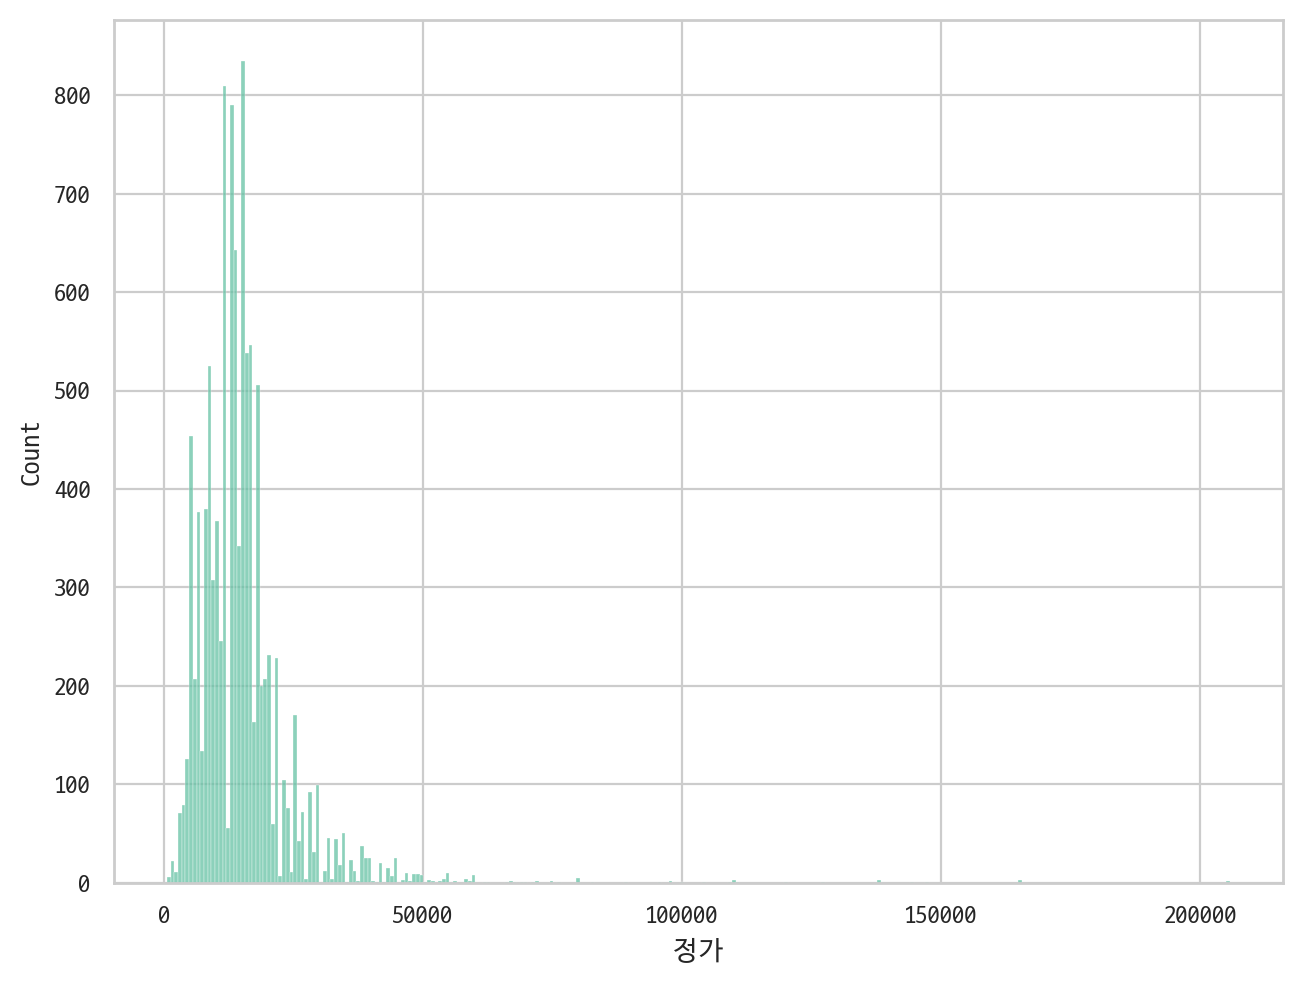

In [21]:
sns.histplot(df_filtered[col]);

판매가
<class 'str'>    10670
Name: count, dtype: int64

/tmp/ipykernel_29909/659068920.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[col] = df_filtered[col].str.replace(',','')


0

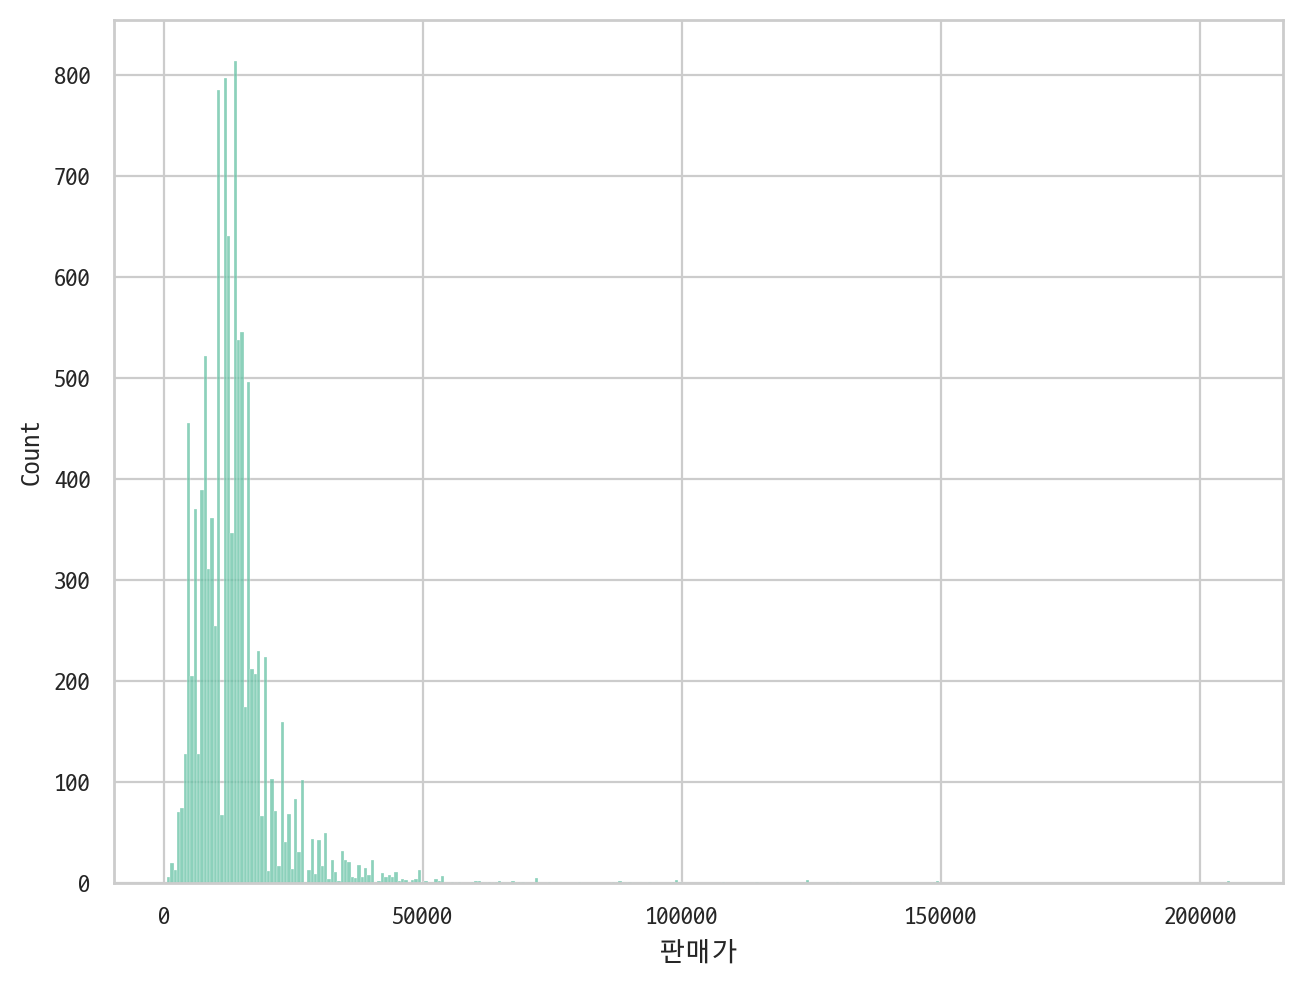

In [22]:
col = '판매가'
display(df_filtered[col].apply(type).value_counts())
df_filtered[col] = df_filtered[col].str.replace(',','')
temp = pd.to_numeric(df_filtered[col],errors='coerce')
display(np.sum(temp.isna()))
sns.histplot(temp);

In [23]:
df_filtered[col] = temp

/tmp/ipykernel_29909/3546829966.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[col] = temp


출간일
<class 'float'>    10670
Name: count, dtype: int64

0

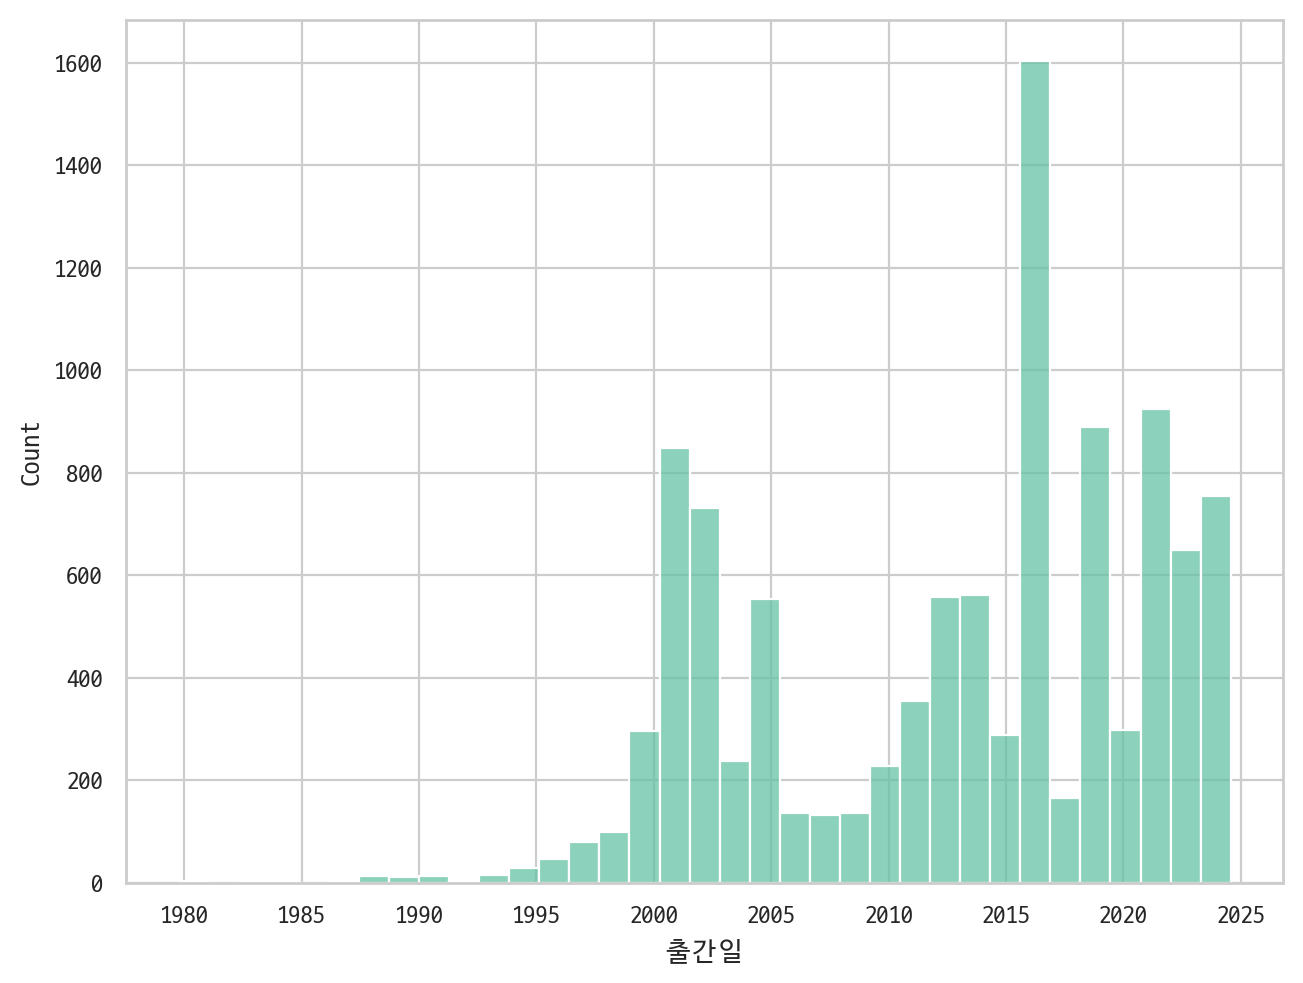

In [24]:
col = '출간일'
display(df_filtered[col].apply(type).value_counts())
temp = df_filtered[col].astype(int).astype(str)
temp = pd.to_datetime(temp,format='%Y%m%d')
sns.histplot(temp);
display(np.sum(temp.isna()))

In [25]:
df_filtered[col] = temp

/tmp/ipykernel_29909/3546829966.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[col] = temp


### 중복 확인

In [26]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10670 entries, 0 to 999
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   순번/순위       10670 non-null  float64       
 1   구분          10670 non-null  object        
 2   상품명         10670 non-null  object        
 3   ItemId      10670 non-null  object        
 4   ISBN13      10603 non-null  object        
 5   부가기호        9116 non-null   object        
 6   저자/아티스트     10670 non-null  object        
 7   출판사/제작사     10670 non-null  object        
 8   출간일         10670 non-null  datetime64[ns]
 9   정가          10670 non-null  int64         
 10  판매가         10670 non-null  int64         
 11  마일리지        10670 non-null  object        
 12  세일즈포인트      10670 non-null  float64       
 13  대표분류(대분류명)  10670 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(9)
memory usage: 1.2+ MB


In [27]:
len(df_filtered['ItemId'].unique())

9328

In [28]:
df_filtered[df_filtered[['상품명','ItemId','저자/아티스트','출판사/제작사','출간일','정가','판매가','ISBN13']].duplicated(keep=False)]

,순번/순위,구분,상품명,ItemId,ISBN13,부가기호,저자/아티스트,출판사/제작사,출간일,정가,판매가,마일리지,세일즈포인트,대표분류(대분류명)
16,17.0,국내도서,리틀 라이프 1,85887573,9788952776372,4840,"한야 야나기하라 지음, 권진아 옮김",시공사,2016-06-16,14800,13320,740점,114925.0,소설/시/희곡
19,20.0,국내도서,해커스 토익 기출 VOCA (보카),176021392,9788965422785,13740,David Cho 지음,해커스어학연구소(Hackers),2023-07-24,12900,11610,640점,232804.0,외국어
25,26.0,국내도서,리틀 라이프 2,85887803,9788952776389,4840,"한야 야나기하라 지음, 권진아 옮김",시공사,2016-06-16,14800,13320,740점,88108.0,소설/시/희곡
29,30.0,국내도서,모순,25843736,9788998441012,3810,양귀자 지음,쓰다,2013-04-01,13000,11700,650점,129526.0,소설/시/희곡
80,81.0,국내도서,EBS 다큐프라임 자본주의,31642609,9788957365793,3320,EBS 자본주의 제작팀 지음,가나출판사,2013-09-27,17000,15300,850점,93872.0,경제경영
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
963,964.0,국내도서,"엄마, 나는 자라고 있어요",882497,9788937831652,3370,"헤티 판 더 레이트.프란스 X. 프로에이 지음, 유영미 옮김, 김수연 감수",북폴리오,2007-01-31,18500,16650,920점,12770.0,좋은부모
966,967.0,국내도서,위험한 과학책,56836932,9788952773326,3400,"랜들 먼로 지음, 이지연 옮김, 이명현 감수",시공사,2015-04-24,22000,19800,"1,100점",25583.0,과학
967,968.0,국내도서,보도 섀퍼의 돈,410811,9788919205013,3320,"보도 섀퍼 지음, 이병서 옮김",에포케,2011-05-17,16700,15030,830점,50922.0,경제경영
970,971.0,국내도서,해커스 그래머 게이트웨이 인터미디엇: 영어가 쉬워지는 기초 영문법 (Grammar ...,44564820,9788965420774,13740,해커스어학연구소 편집부 엮음,해커스어학연구소(Hackers),2021-12-13,14900,13410,740점,19771.0,외국어


In [29]:
df_filtered[df_filtered['ItemId'].duplicated(keep=False)].sort_values(by='ItemId')

,순번/순위,구분,상품명,ItemId,ISBN13,부가기호,저자/아티스트,출판사/제작사,출간일,정가,판매가,마일리지,세일즈포인트,대표분류(대분류명)
5,6.0,국내도서,채식주의자,1000152,9788936433598,3810.0,한강 지음,창비,2007-10-30,12000,10800,600점,57521.0,소설/시/희곡
900,901.0,국내도서,채식주의자,1000152,9788936433598,3810,한강 지음,창비,2007-10-30,12000,10800,600점,57521.0,소설/시/희곡
0,1.0,국내도서,채식주의자,1000152,9788936433598,3810.0,한강 지음,창비,2007-10-30,12000,10800,600점,57521.0,소설/시/희곡
119,120.0,국내도서,영어 글쓰기의 기본,1002280,9788995637159,3740.0,"윌리엄 스트렁크 지음, 조서연.김지양 옮김, 곽중철 감수",인간희극,2007-11-19,7500,6750,370점,15552.0,외국어
182,183.0,국내도서,영어 글쓰기의 기본,1002280,9788995637159,3740.0,"윌리엄 스트렁크 지음, 조서연.김지양 옮김, 곽중철 감수",인간희극,2007-11-19,7500,6750,370점,15552.0,외국어
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,62.0,국내도서,7년의 밤,9886703,9788956604992,3810.0,정유정 지음,은행나무,2011-03-23,14500,13050,720점,41675.0,소설/시/희곡
544,545.0,국내도서,어린이와 그림책,99079,9788946412002,4370.0,마쯔이 다다시,샘터사,2003-07-25,8000,7200,400점,5676.0,좋은부모
884,885.0,국내도서,어린이와 그림책,99079,9788946412002,4370.0,마쯔이 다다시,샘터사,2003-07-25,8000,7200,400점,5676.0,좋은부모
344,345.0,국내도서,직장인을 위한 실무 엑셀,99386523,9791160500790,3000,선양미 지음,길벗,2019-03-04,21000,18900,"1,050점",9944.0,컴퓨터/모바일


In [30]:
cond1= df_filtered['ItemId'].duplicated(keep=False)
cond2= df_filtered[['ItemId','세일즈포인트']].duplicated(keep=False)
df_filtered[cond1&(~cond2)].sort_values(by=['ItemId','세일즈포인트'])

,순번/순위,구분,상품명,ItemId,ISBN13,부가기호,저자/아티스트,출판사/제작사,출간일,정가,판매가,마일리지,세일즈포인트,대표분류(대분류명)
699,700.0,국내도서,하나님의 열심,127247882,9791187506072,3230,박영선 지음,무근검(남포교회출판부),2017-12-29,20000,18000,"1,000점",33919.0,종교/역학
712,713.0,국내도서,하나님의 열심,127247882,9791187506072,3230.0,박영선 지음,무근검(남포교회출판부),2017-12-29,20000,18000,"1,000점",34025.0,종교/역학
648,649.0,국내도서,불안,14350678,9788956605593,3840,"알랭 드 보통 지음, 정영목 옮김",은행나무,2011-12-28,15000,13500,750점,39468.0,에세이
596,597.0,국내도서,노인과 바다,14522431,9788937462788,4800,"어니스트 헤밍웨이 지음, 김욱동 옮김",민음사,2012-01-02,8000,7200,400점,35441.0,소설/시/희곡
279,280.0,국내도서,참을 수 없는 존재의 가벼움,152511699,9788937437564,3860,"밀란 쿤데라 지음, 이재룡 옮김",민음사,2018-06-20,17000,15300,850점,82794.0,소설/시/희곡
845,846.0,국내도서,한국단편소설 40,156445263,9788965820475,44810,"김동인 외 지음, 박찬영 외 엮음",리베르,2018-07-16,16800,15120,840점,27569.0,청소년
661,662.0,국내도서,한국단편소설 40,156445263,9788965820475,44810,"김동인 외 지음, 박찬영 외 엮음",리베르,2018-07-16,16800,15120,840점,28030.0,청소년
297,298.0,국내도서,해커스톡 여행영어 10분의 기적,176569924,9788965422778,13740,해커스어학연구소 지음,해커스어학연구소(Hackers),2019-01-02,9800,8820,490점,24844.0,외국어
764,765.0,국내도서,해커스톡 여행영어 10분의 기적,176569924,9788965422778,13740,해커스어학연구소 지음,해커스어학연구소(Hackers),2019-01-02,9800,8820,490점,25364.0,외국어
681,682.0,국내도서,페인트 (반양장),189589576,9788936456894,43810,이희영 지음,창비,2019-04-19,13000,11700,650점,42686.0,청소년


In [31]:
np.sum(df_filtered.loc[cond1&(~cond2),'ItemId'].value_counts() == 1)

14

- 예상보다는 중복이 많지 않음
- ItemId 중복 == '상품명','ItemId','저자/아티스트','출판사/제작사','출간일','정가','판매가' 중복
    - 위의 것들이 중복되지만 세일즈프인트가 중복되지 않는 케이스가 존재
    - 세일즈포인트, 판매가, 정가에 대해서 현재의 값과 대조 필요
        - 세일즈포인트의 경우, 업데이트 되는 시간대에 걸쳐서 파일들을 다운받았기 때문일 수 있음
- 저자 이름이 다 들어간 케이스와 '000 외'로 들어간 케이스를 어떻게 통일할지 차후에 정해야 함
- 저자 이름 전처리 필요
    - 지음, 엮음, 옮김, 감수 등으로 구별하는 것이 좋을 듯
    - 저자 : 지음 / 참여자 : (기타 담당) 으로 분리하는 것 필요
- pd.duplicated에서 한 번만 등장하는 itemid가 있는 이유 파악 필요

In [ ]:
book_df = pd.DataFrame(columns=['ID', 'Title', 'Rating', 'Author', 'Price', 'Pdate', 'Publisher', 'Btype', 'Salseindex'])



In [ ]:
# 가져올 책 범위,ID.. 값 정의
start_id = 97043285 # 125190808
end_id = 97046595





In [ ]:
# ID를 증가시키며 책 정보 크롤링
for book_id in range(start_id, end_id + 1):
    url = f'http://www.yes24.com/Product/Goods/{book_id}'
    try:
        r = requests.get (url)
        if r.status_code == 200:
            html=r.text
            soup=BeautifulSoup(html, 'lxml') #  BeautifulSoup 클래스의 인스턴스 생성

            # title = soup.select_one('#yDetailTopWrap > div.topColRgt > div.gd_infoTop > div > h2').get_text()
            try:
                title = soup.select_one('#yDetailTopWrap > div.topColRgt > div.gd_infoTop > div > h2').get_text()
            except AttributeError:
                title = None # 선택한 요소가 없어서 발생하는 AttributeError 처리

            try:
                rating = soup.select_one('#spanGdRating > a > em').get_text() # .get_text().strip()
            except AttributeError:
                rating = None

            try:
                author = soup.select_one('#yDetailTopWrap > div.topColRgt > div.gd_infoTop > span.gd_pubArea > span.gd_auth > a').get_text()
            except AttributeError:
                author = None

            btype = 'new'
            try:
                # if soup.select_one('#yDetailTopWrap > div.topColRgt > div.gd_infoTop > div > strong > em').get_text() == "중고도서":
                if "중고도서" in soup.select_one('#yDetailTopWrap > div.topColRgt > div.gd_infoTop > div > strong > em').get_text().lower():
                    price = soup.select_one('#yDetailTopWrap > div.topColRgt > div.gd_infoBot > div.gd_infoTbArea > div:nth-child(1) > table > tbody > tr.accentRow > td > span > em').get_text()  # 판매가격
                    btype = 'old'
                else:
                    price = soup.select_one('#yDetailTopWrap > div.topColRgt > div.gd_infoBot > div.gd_infoTbArea > div:nth-child(3) > table > tbody > tr:nth-child(2) > td > span > em').get_text()  # 판매가격
            except AttributeError:
                price = None

            try:
                pdate = soup.select_one('#yDetailTopWrap > div.topColRgt > div.gd_infoTop > span.gd_pubArea > span.gd_date').get_text()   # 발행일
            except AttributeError:
                pdate = None

            try:
                publisher = soup.select_one('#yDetailTopWrap > div.topColRgt > div.gd_infoTop > span.gd_pubArea > span.gd_pub > a').get_text()  # 출판사
            except AttributeError:
                publisher = None

            try:
                numbers = re.findall(r'\d+', soup.select_one('#yDetailTopWrap > div.topColRgt > div.gd_infoTop > span.gd_ratingArea > span.gd_sellNum').get_text().replace(',', ''))
                number = int(numbers[0]) if numbers else None
                salseindex = number # soup.select_one('#yDetailTopWrap > div.topColRgt > div.gd_infoTop > span.gd_ratingArea > span.gd_sellNum').get_text()  # 판매지수
            except AttributeError:
                salseindex = None



            # book_df = book_df.append({'ID':book_id, 'Title':title, 'Author':author, 'Rating':rating, 'Price':price, 'Pdate':pdate, 'Publisher':publisher, 'Btype':btype}, ignore_index=True)
            new_row = pd.DataFrame({'ID': [book_id], 'Title': [title], 'Author': [author], 'Rating': [rating], 'Price': [price], 'Pdate': [pdate], 'Publisher': [publisher], 'Btype': [btype], 'Salseindex': [salseindex]})
            book_df = pd.concat([book_df, new_row], ignore_index=True)

        else:
            print('에러발생1')
    except requests.RequestException as e:
        # 에러 발생시....
        print('에러발생2')
# book_df
book_df.to_csv('book.csv', encoding='euc-kr')
